# REINFORCE
- What is REINFORCE: tune the network weight to increase the probability of good actions and decrease the probability of bad actions; it is a policy-based method to estimate the weight of an optimal policy through gradient ascend.

- How REINFORCE works for DRL?

> 1. use the policy $\pi_\theta$ to collect m trajectories ${ \tau^{(1)}, \tau^{(2)}, ..., \tau^{(m)}}$ with Horizon H. Here the $i$ th trajectory is

> $\tau^{(i)} = (s_0^{(i)},a_0^{(i)}, ..., s_H^{(i)},a_H^{(i)},s_{H+1}^{(i)})$

> 2. use the trajectories to estimate the gradient $\nabla_\theta U(\theta) \approx \hat{g} := \frac{1}{m}\sum_{i=1}^m \sum_{t=0}^{H} \nabla_\theta \log \pi_\theta(a_t^{(i)}|s_t^{(i)}) R(\tau^{(i)})$

> 3. Update the weights of the policy:
$\theta \leftarrow \theta + \alpha \hat{g}$

> 4. Loop over steps 1-3.


- When & Where to use REINFORCE?

- Why REINFORCE vs. other policy-based method?

## 1. Import Packages

In [13]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
%matplotlib inline

import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

## 2. Instantiate Env and Agent

In [21]:
env = gym.make('CartPole-v0')
env.seed(0)
print('Observation space: ', env.observation_space)
print('Action space: ', env.action_space)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=6, a_size=2):
        super(Policy, self).__init__()
        self.fc1=nn.Linear(s_size, h_size)
        self.fc2=nn.Linear(h_size, a_size)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        return F.softmax(x, dim=1) #prob(action)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

    
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

Observation space:  Box(4,)
Action space:  Discrete(2)


## 3. Train the agent with REINFORCE

In [22]:
def reinforce(n_episodes=1000, max_t=1000, gamma=.990, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores
    
scores = reinforce()

Episode 100	Average Score: 24.64
Episode 200	Average Score: 42.61
Episode 300	Average Score: 63.36
Episode 400	Average Score: 68.43
Episode 500	Average Score: 109.47
Episode 600	Average Score: 96.20
Episode 700	Average Score: 75.21
Episode 800	Average Score: 93.18
Episode 900	Average Score: 185.10
Episode 1000	Average Score: 194.28


## 4. Plot the scores

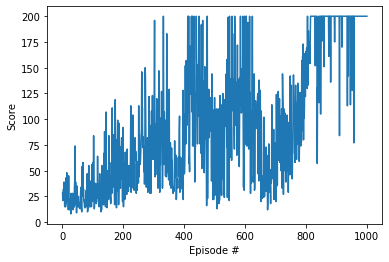

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 5. Watch a smart agent to perform

In [24]:
env = gym.make('CartPole-v0')

state = env.reset()
for t in range(10000):
    action, _ = policy.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break
env.close()